<a href="https://colab.research.google.com/github/Maryam-Afshari/thesis/blob/master/Lobith_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking out the GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  5 14:08:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# checking out the memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Running LSTM on Lobith station 

In [3]:
#!pip install keras_tuner

In [4]:
#!pip install hydroeval

In [ ]:
# required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading data
df_l = pd.read_csv('/content/drive/MyDrive/Thesis-Afshari/data/lobith.csv',index_col=0)
q_lobith = pd.read_csv("/content/drive/MyDrive/Thesis-Afshari/data/q_lobith.csv",index_col=0)


In [ ]:
# inspecting data
df_l.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001813,0.001265,0.000106,0.000604,0.001578,0.002820,0.005944
p,7305.0,0.002575,0.003405,0.000000,0.000043,0.001207,0.003869,0.029550
t,7305.0,9.002240,7.177492,-17.833004,3.631933,9.177105,14.708690,26.345102
obs,7305.0,2359.275838,1246.986091,794.000000,1511.000000,2020.000000,2801.000000,11885.000000


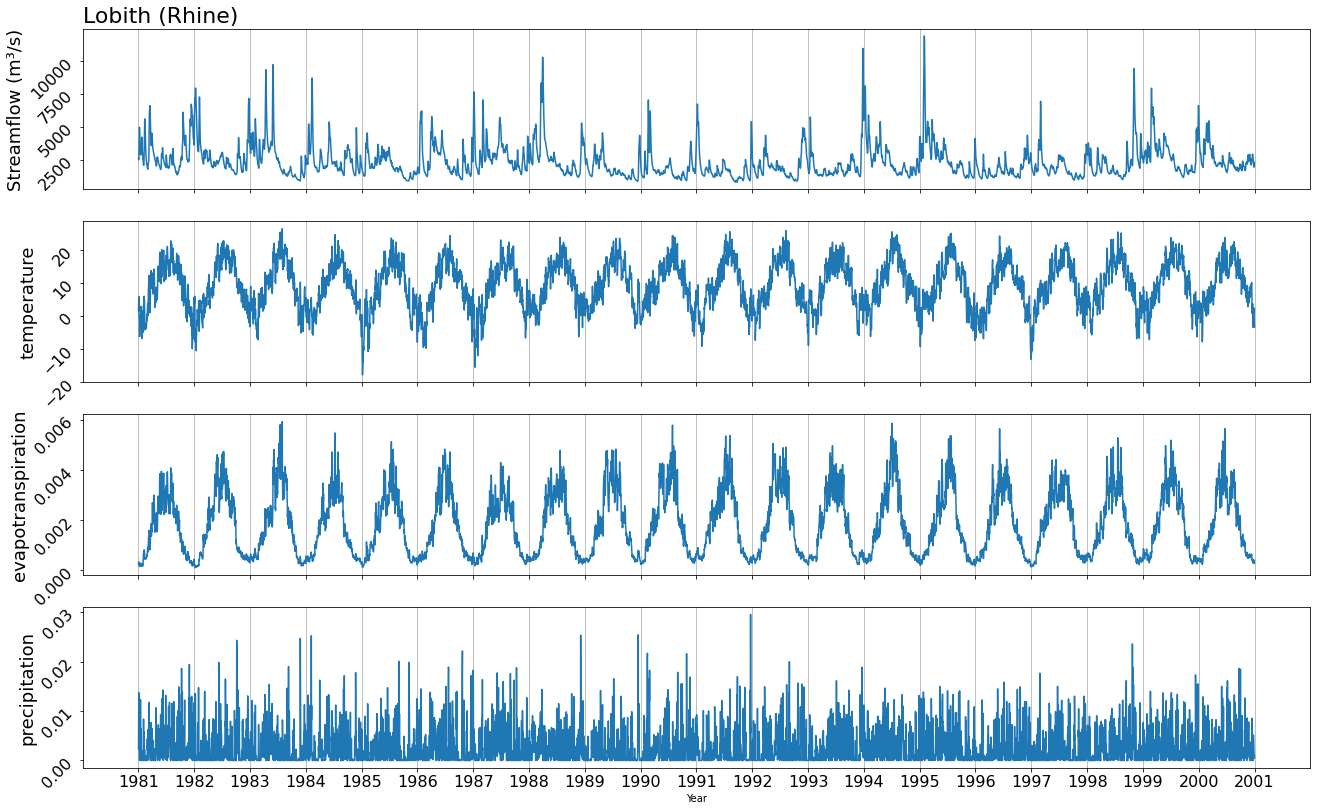

In [ ]:
# plot data
shown_data = 0.5
len = df_l.shape[0]
# variables to plot
obs_l = df_l.obs.values
t_l = df_l.t.values
et_l = df_l.et.values
p_l = df_l.p.values
date = df_l.datetime.str[:4].values

# plot the variables
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(22, 22*2/(1+5**0.5)))
ax1.plot(obs_l)
ax2.plot(t_l)
ax3.plot(et_l)
ax4.plot(p_l)


# set the ticks
days_per_year = [0]+[365, 365, 365, 366]*5
ticks = np.cumsum(days_per_year[:-1])[:int(40*shown_data)]
plt.xticks(ticks.tolist() + [len], 
           date[ticks].tolist() + [str(int(date[-1]) + 1)])
# tweak the axes
ax1.set_title('Lobith (Rhine)', loc ="left", fontsize =22)
ax4.set_xlabel('Year')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 18)
ax2.set_ylabel('temperature', fontsize = 18)
ax3.set_ylabel('evapotranspiration', fontsize = 18)
ax4.set_ylabel('precipitation', fontsize = 18)

for ax in (ax1, ax2, ax3, ax4):
  ax.grid(axis = 'x')
  ax.tick_params(axis='y', labelsize=16,  rotation = 45)
  ax.tick_params(axis='x', labelsize=16)

plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/timeseries_lobith.png") 



## Data prep

In [ ]:
# train test split
len_ = int(0.75 * df_l.shape[0])

df_train = df_l[:len_]
df_test = df_l[len_:]

In [ ]:
# x  and y train
X_train = df_train[["et","t","p"]]
y_train = df_train.obs

# x and y test
X_test = df_test[["et","t","p"]]
y_test = df_test.obs

In [ ]:
# normalising data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
# normalising output
y_train_shaped = np.reshape(y_train.values, (y_train.shape[0],1))
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_shaped)
y_test_shaped = np.reshape(y_test.values, (y_test.shape[0],1))
y_test_scaled = scaler.transform(y_test_shaped)
y_test_scaled.shape

(1827, 1)

In [ ]:
# a fuction to make 3D data to feed into the LSTM model
# https://towardsdatascience.com/how-to-reshape-data-and-do-regression-for-time-series-using-lstm-133dad96cd00

def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
# defiene the number of steps based on cross-corelation plots 
num_steps = 55

# training set
(X_train_transformed,
 y_train_transformed) = lstm_data_transform(X_train, y_train_scaled, num_steps=num_steps)
assert X_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(X_test_transformed,
 y_test_transformed) = lstm_data_transform(X_test, y_test_scaled, num_steps=num_steps)
assert X_test_transformed.shape[0] == y_test_transformed.shape[0]

In [ ]:
# saving obs of test set
y_hat_inversed = scaler.inverse_transform(y_test_transformed) 
y_hat_inversed

np.save("/content/drive/MyDrive/Thesis-Afshari/output/obs_lobith_55lag.npy", y_hat_inversed, allow_pickle=True)

## Hyperparameter optimization

In [ ]:
# define the baseline model
def build_baseline_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.01, 0.001])), metrics = ['mse'])
    return model

In [ ]:
# instantiate the Hyperband tuner
tuner = kt.Hyperband(build_baseline_model,
                     overwrite=True,
                     objective='mse',
                     max_epochs=20, 
                     factor=3,
                     hyperband_iterations = 1,
                     directory='/content/drive/MyDrive/Thesis-Afshari/output/hyperparameter_tunning',
                     project_name='LSTM_Lobith_hyperparameter_tunning_lag55_2')

In [ ]:
# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

# run the tuner
tuner.search(X_train_transformed, y_train_transformed, epochs=25, validation_split=0.2, callbacks=[es]) # epoch =20

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 01m 10s]
mse: 0.03280164673924446

Best mse So Far: 0.0025063881184905767
Total elapsed time: 00h 15m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# geting the optimal params in a dict to save it
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# reading the optimal params in a df
dict_ = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
lstm_best_params = pd.DataFrame([dict_])
lstm_best_params

,input_unit,n_layers,lstm_0_units,layer_2_neurons,Dropout_rate,dense_activation,learning_rate,lstm_1_units,lstm_2_units,lstm_3_units,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,tuner/trial_id
0,64,2,192,480,0.1,tanh,0.001,448,288,352,20,7,2,2,0013


In [ ]:
# saving best params in csv file 
lstm_best_params.to_csv("/content/drive/MyDrive/Thesis-Afshari/output/lobith/lstm_best_params_55lag_lobith_2.csv")

# Single model run

In [ ]:
%%time
# building the model based on optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# create a callback to stop training early after reaching a certain value for the validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

# run the model
history = best_model.fit(X_train_transformed, y_train_transformed,
            validation_split= 0.2,
            epochs=1000,
            batch_size= 32, # tried it with 16 | 128  | 512
            callbacks=[es])

Epoch 1/1000
136/136 [==============================] - 11s 34ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 3/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 4/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 5/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/1000
136/136 [==============================] 

In [ ]:
# summary of the model
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 55, 64)            17408     
                                                                 
 lstm_6 (LSTM)               (None, 55, 192)           197376    
                                                                 
 lstm_7 (LSTM)               (None, 55, 448)           1148672   
                                                                 
 lstm_8 (LSTM)               (None, 480)               1783680   
                                                                 
 dropout_1 (Dropout)         (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 481       
                                                                 
Total params: 3,147,617
Trainable params: 3,147,617
No

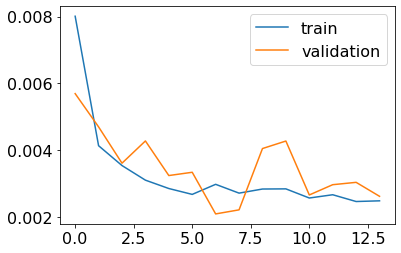

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Evaluation

In [ ]:
# mse evaluation
res = best_model.evaluate(X_test_transformed, y_test_transformed, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0017


In [ ]:
# prediting 
y_pred = best_model.predict(X_test_transformed)
# nse evaluation
nse = he.evaluator(he.nse,y_pred,y_test_transformed)
nse[0]

0.825011497457263

In [ ]:
# kge evaluation
kge = he.evaluator(he.kge, y_pred, y_test_transformed)
kge[0]

array([0.83608822])

### Saving Model

In [ ]:
# serialize model to JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
best_model.save_weights("/content/drive/MyDrive/Thesis-Afshari/output/lobith/lstm_model_lobith_55lag_2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Thesis-Afshari/output/lobith/lstm_model_lobith_55lag_2.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# evaluate the loaded model on test data 
# complie the loaded model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loaded_model.compile(loss='mean_squared_error',optimizer= optimizer , metrics = ['mse'])
score = loaded_model.evaluate(X_test_transformed, y_test_transformed, verbose=0)
print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0017


## Ensemble runs

In [ ]:
%%time
# define a function to run the model multiple times
def train_multiple_times():
    # define the model
    model_ = tuner.hypermodel.build(best_hps)
    # create a callback to stop training early after reaching a certain value for the validation loss
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    # fit the model
    model_.fit(X_train_transformed, y_train_transformed,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32,
            callbacks=[es])
    # make predictions
    y_pred = model_.predict(X_test_transformed)
    # invert predictions
    y_pred_inversed = scaler.inverse_transform(y_pred)

    # evaluate model with nse
    nse = he.evaluator(he.nse,y_pred,y_test_transformed)
    # evaluate model with kge
    kge = he.evaluator(he.kge, y_pred, y_test_transformed)
    return (nse, kge[0], y_pred_inversed)


nse = []
kge = []
y_pred = []
repeats = 10

# a for loop for running model 10 times
for t in range(repeats):
    # call the function
    nse_multiple, kge_multiple, y_pred_inversed = train_multiple_times()
    # append the nse list above nse values 
    nse.append(nse_multiple)
    # append the kge list above kge values
    kge.append(kge_multiple)
    # append the y_pred list above predictions
    y_pred.append(y_pred_inversed)

    print(f'For {t} time running model, the NSE is : {nse_multiple}')
    print(f'For {t} time running model, the KGE is : {kge_multiple}')

Epoch 1/1000
136/136 [==============================] - 11s 34ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/1000
136/136 [==============================] - 3s 25ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/1000
136/136 [==============================] 

In [ ]:
# convert y_pred to an array
y_pred_array = np.array(y_pred)

# dimension of y_pred array
y_pred_array.shape

(10, 1772, 1)

In [ ]:
# taking the mean of y_preds over 10 time predictions 
y_df = pd.DataFrame(y_pred_array.mean(axis=0))

# changing the name of the column
y_df.columns = ["y_pred"]

# saving the calculated mean to a csv file
y_df.to_csv("/content/drive/MyDrive/Thesis-Afshari/output/lobith/y_pred_lobith_lstm_10_55lag_2.csv")

In [ ]:
# saving y_pred to an numpy array 
np.save("/content/drive/MyDrive/Thesis-Afshari/output/lobith/y_pred_lobith_lstm_10_55lag_2.npy", y_pred_array, allow_pickle=True)
# loading y_pred array 
y_pred_loaded = np.load("/content/drive/MyDrive/Thesis-Afshari/output/lobith/y_pred_lobith_lstm_10_55lag_2.npy", allow_pickle=True)
# checking the shape of y_pred array
y_pred_loaded.shape

(10, 1772, 1)

In [ ]:
# making the NSE list an numpy array
nse = np.array(nse)
# saving NSE numpy array
np.save("/content/drive/MyDrive/Thesis-Afshari/output/lobith/nse_lobith_ave10_55lag_2.npy", nse, allow_pickle=True)

# loading NSE array
nse_loaded = np.load("/content/drive/MyDrive/Thesis-Afshari/output/lobith/nse_lobith_ave10_55lag_2.npy",allow_pickle=True)


# mean and sd of NSE array
nse_mean = np.mean(nse_loaded)
nse_sd = np.std(nse_loaded)
print(f'mean NSE is : {nse_mean}')
print(f'Standard devation of NSE over 10 times running model is : {nse_sd}')

mean NSE is : 0.7987916741301222
Standard devation of NSE over 10 times running model is : 0.02680911021133425


In [ ]:
# making the KGE list an numpy array
kge = np.array(kge)
np.save("/content/drive/MyDrive/Thesis-Afshari/output/lobith/kge_lobith_ave10_55lag_2.npy", kge, allow_pickle=True)
# saving KGE numpy array
kge_loaded = np.load("/content/drive/MyDrive/Thesis-Afshari/output/lobith/kge_lobith_ave10_55lag_2.npy",allow_pickle=True)

# mean and sd of KGE
kge_mean = np.mean(kge_loaded)
kge_sd = np.std(kge_loaded)
print(f'mean KGE is : {kge_mean}')
print(f'Standard deviation of KGE over 10 times running model is : {kge_sd}')

mean KGE is : 0.8470331775355893
Standard deviation of KGE over 10 times running model is : 0.04251359185230787


## Prediction

In [ ]:
# reading y_pred from csv file
Y_df = pd.read_csv("/content/drive/MyDrive/Thesis-Afshari/output/lobith/y_pred_lobith_lstm_10_55lag_2.csv",index_col=0)
# add the date of test period to the y_pred dataset 
Y_df['date'] = pd.date_range(start = "2/25/1996", periods =1772, freq = "D") 
Y_pred = Y_df.y_pred.values

# PCR

In [ ]:
# getting the result of pcr model


# train test split
len_ = int(0.75 * q_lobith.shape[0])

# making test and train sets 
df_train_pcr = q_lobith[:len_]
df_test_pcr = q_lobith[len_:]


# x and y test
X_test_pcr = df_test_pcr.obs
y_test_pcr = df_test_pcr.pcr

# making data in right shape for the LSTM model 
num_steps = 55

# transforming the test set to 3D shape for the LSTM model 
(X_test_pcr_transformed,
 y_test_pcr_transformed) = lstm_data_transform(X_test_pcr, y_test_pcr, num_steps=num_steps)
assert X_test_pcr_transformed.shape[0] == y_test_pcr_transformed.shape[0]

# Visualisation 

In [ ]:
# variables to plot
Y_test = scaler.inverse_transform(y_test_transformed)
predicted = Y_df.y_pred
pcr_prediction = y_test_pcr_transformed
date = Y_df.date
print(Y_test.shape, predicted.shape, pcr_prediction.shape, date.shape)

(1772, 1) (1772,) (1772,) (1772,)


No handles with labels found to put in legend.


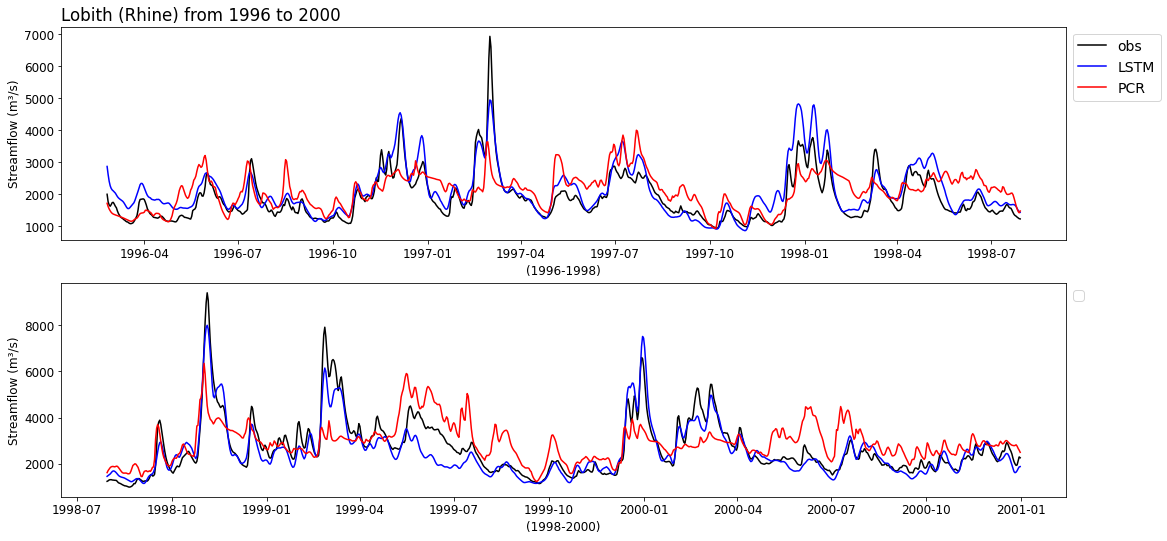

In [ ]:
# plot performance of the LSTM,PCR models' prediction and the actual values in test set in two different subplots

# get the length of the variables in order to divide them to two sections 
len_ = int(0.5 * Y_test.shape[0])
len_

# years to plot
date_1 = Y_df.date[:len_]

date_2 = Y_df.date[len_:]

# dividing variables to two sets
actual_1 = Y_test[:len_]
actual_2 = Y_test[len_:]

predicted_1 = Y_df.y_pred[:len_]
predicted_2 = Y_df.y_pred[len_:]

pcr_prediction_1 = pcr_prediction[:len_]
pcr_prediction_2 = pcr_prediction[len_:]

# plot the variables
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(18, 18*2/(1+10**0.5)))
ax1.plot(date_1, actual_1, "black",label ="obs")
ax1.plot(date_1, predicted_1, "b", label = "LSTM")
ax1.plot(date_1, pcr_prediction_1,"r", label = "PCR")

ax2.plot(date_2, actual_2,"black")
ax2.plot(date_2, predicted_2,"b")
ax2.plot(date_2, pcr_prediction_2, "r")


# tweak the axes
ax1.set_title('Lobith (Rhine) from 1996 to 2000', loc ="left")
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 12) 
ax2.set_ylabel('Streamflow (m³/s)', fontsize = 12)
ax1.set_xlabel('(1996-1998)', fontsize =12)
ax2.set_xlabel('(1998-2000)', fontsize =12)

for ax in (ax1, ax2):
  ax.tick_params(axis='y', labelsize=12)
  ax.tick_params(axis='x', labelsize=12)
  ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  

plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/1996-2000_lobith_lstm_55lag_new.png")